# 탐색적 데이터 분석 (EDA)

이 노트북에서는 AI 생성 이미지와 실제 이미지 데이터셋을 탐색하고 분석합니다.

## 목표
- 데이터 분포 및 클래스 불균형 파악
- 이미지 해상도 및 품질 분석
- 노이즈 수준 확인
- 샘플 이미지 시각화
- "왜 이 데이터가 어려운가?" 문제 정의


In [1]:
# 필요한 라이브러리 import
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("라이브러리 로드 완료!")


라이브러리 로드 완료!


## 데이터 경로 설정


In [2]:
# 데이터 경로 설정
DATA_DIR = Path("../data")
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"
TEST_DIR = DATA_DIR / "test"

# 분석할 데이터셋 선택 (raw 또는 processed)
ANALYZE_RAW = True  # True: 원본 데이터 분석, False: 전처리된 데이터 분석

if ANALYZE_RAW:
    BASE_DIR = RAW_DATA_DIR
    print("📁 원본 데이터 분석 모드")
else:
    BASE_DIR = PROCESSED_DATA_DIR / "all"
    print("📁 전처리된 데이터 분석 모드")

print(f"분석 대상 경로: {BASE_DIR}")


📁 원본 데이터 분석 모드
분석 대상 경로: ../data/raw


## 1. 기본 데이터 통계


In [3]:
def collect_image_statistics(base_dir):
    """
    이미지 파일 통계 수집
    
    Returns:
        stats: 이미지 통계 딕셔너리
    """
    stats = {
        'total_images': 0,
        'by_category': {},
        'by_dataset': {},
        'image_paths': [],
        'categories': [],
        'datasets': []
    }
    
    # 이미지 확장자
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
    
    # 데이터셋별로 탐색
    if BASE_DIR.name == "raw":
        # 원본 데이터: dataset_1, dataset_2, dataset_3 구조
        for dataset_dir in BASE_DIR.iterdir():
            if not dataset_dir.is_dir():
                continue
            
            dataset_name = dataset_dir.name
            dataset_count = 0
            
            # 재귀적으로 이미지 파일 찾기
            for img_path in dataset_dir.rglob("*"):
                if img_path.suffix.lower() in image_extensions:
                    stats['total_images'] += 1
                    dataset_count += 1
                    stats['image_paths'].append(img_path)
                    
                    # 카테고리 추출
                    category = None
                    for part in img_path.parts:
                        part_lower = part.lower()
                        if part_lower in ['real', 'authentic']:
                            category = 'real'
                            break
                        elif part_lower in ['fake', 'ai', 'generated']:
                            category = 'fake'
                            break
                    
                    if category:
                        stats['categories'].append(category)
                        if category not in stats['by_category']:
                            stats['by_category'][category] = 0
                        stats['by_category'][category] += 1
                    
                    stats['datasets'].append(dataset_name)
            
            if dataset_count > 0:
                stats['by_dataset'][dataset_name] = dataset_count
    
    else:
        # 전처리된 데이터: 카테고리별 디렉토리 구조
        for category_dir in BASE_DIR.iterdir():
            if not category_dir.is_dir():
                continue
            
            category = category_dir.name
            category_count = 0
            
            for img_path in category_dir.glob("*"):
                if img_path.suffix.lower() in image_extensions:
                    stats['total_images'] += 1
                    category_count += 1
                    stats['image_paths'].append(img_path)
                    stats['categories'].append(category)
                    
                    # 데이터셋 이름 추출 (파일명에서)
                    dataset_name = img_path.name.split('_')[0] if '_' in img_path.name else 'unknown'
                    stats['datasets'].append(dataset_name)
            
            stats['by_category'][category] = category_count
    
    return stats

# 통계 수집
print("📊 이미지 통계 수집 중...")
stats = collect_image_statistics(BASE_DIR)

print(f"\n✅ 통계 수집 완료!")
print(f"   총 이미지 수: {stats['total_images']:,}개")
print(f"\n📁 카테고리별 분포:")
for cat, count in stats['by_category'].items():
    percentage = (count / stats['total_images']) * 100
    print(f"   - {cat}: {count:,}개 ({percentage:.1f}%)")

if stats['by_dataset']:
    print(f"\n📦 데이터셋별 분포:")
    for ds, count in stats['by_dataset'].items():
        percentage = (count / stats['total_images']) * 100
        print(f"   - {ds}: {count:,}개 ({percentage:.1f}%)")


📊 이미지 통계 수집 중...



✅ 통계 수집 완료!
   총 이미지 수: 91,711개

📁 카테고리별 분포:
   - real: 63,780개 (69.5%)
   - fake: 27,855개 (30.4%)

📦 데이터셋별 분포:
   - dataset_2: 76개 (0.1%)
   - dataset_3: 21,635개 (23.6%)
   - dataset_1: 70,000개 (76.3%)


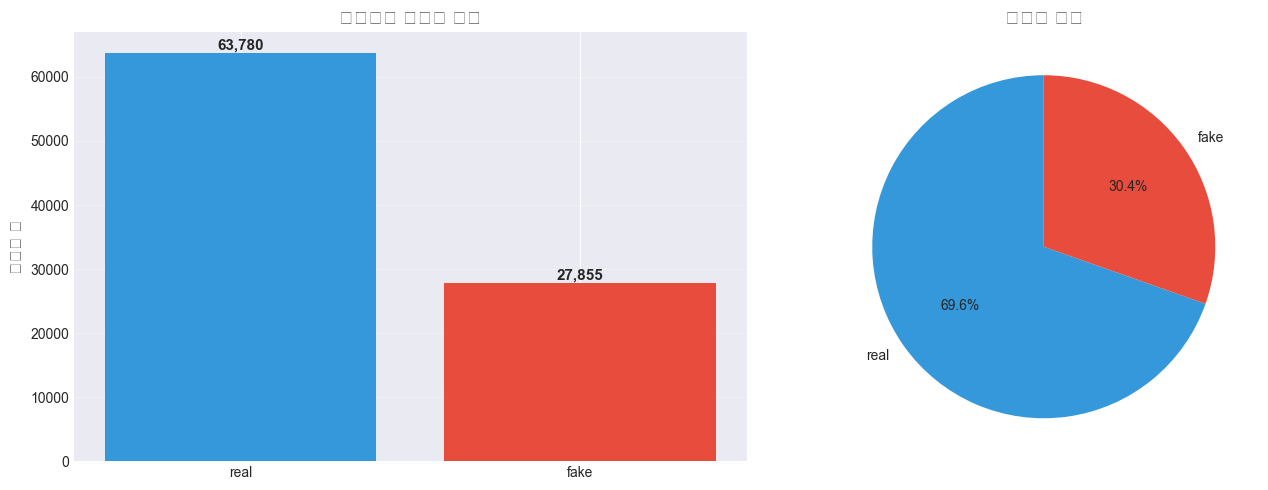


📈 클래스 불균형 비율: 2.29:1
   (가장 많은 클래스 / 가장 적은 클래스)
   ⚠️  약간의 불균형: 주의 필요


In [4]:
# 클래스 불균형 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 카테고리별 분포 막대 그래프
categories = list(stats['by_category'].keys())
counts = list(stats['by_category'].values())
colors = ['#3498db' if cat == 'real' else '#e74c3c' for cat in categories]

axes[0].bar(categories, counts, color=colors)
axes[0].set_title('클래스별 이미지 분포', fontsize=14, fontweight='bold')
axes[0].set_ylabel('이미지 수', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# 값 표시
for i, (cat, count) in enumerate(zip(categories, counts)):
    axes[0].text(i, count, f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. 파이 차트
axes[1].pie(counts, labels=categories, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('클래스 비율', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 불균형 비율 계산
if len(counts) >= 2:
    imbalance_ratio = max(counts) / min(counts)
    print(f"\n📈 클래스 불균형 비율: {imbalance_ratio:.2f}:1")
    print(f"   (가장 많은 클래스 / 가장 적은 클래스)")
    
    if imbalance_ratio > 5:
        print("   ⚠️  심각한 불균형: 데이터 증강 또는 샘플링 전략 필요")
    elif imbalance_ratio > 3:
        print("   ⚠️  중간 정도 불균형: 데이터 증강 권장")
    elif imbalance_ratio > 2:
        print("   ⚠️  약간의 불균형: 주의 필요")
    else:
        print("   ✅ 균형이 잘 맞춰져 있습니다.")


## 3. 이미지 해상도 분석


In [5]:
def analyze_image_resolutions(image_paths, sample_size=1000):
    """
    이미지 해상도 분석
    
    Args:
        image_paths: 이미지 경로 리스트
        sample_size: 분석할 샘플 크기 (전체가 너무 많을 경우)
    """
    resolutions = []
    widths = []
    heights = []
    aspect_ratios = []
    
    # 샘플링 (너무 많으면 일부만 분석)
    if len(image_paths) > sample_size:
        import random
        random.seed(42)
        sampled_paths = random.sample(image_paths, sample_size)
        print(f"⚠️  이미지가 너무 많아 {sample_size}개만 샘플링하여 분석합니다.")
    else:
        sampled_paths = image_paths
    
    print(f"📏 {len(sampled_paths)}개 이미지의 해상도 분석 중...")
    
    for img_path in tqdm(sampled_paths, desc="해상도 분석"):
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                resolutions.append((width, height))
                widths.append(width)
                heights.append(height)
                aspect_ratios.append(width / height if height > 0 else 1.0)
        except Exception as e:
            continue
    
    return {
        'resolutions': resolutions,
        'widths': widths,
        'heights': heights,
        'aspect_ratios': aspect_ratios
    }

# 해상도 분석
resolution_stats = analyze_image_resolutions(stats['image_paths'])

# 통계 출력
print(f"\n✅ 해상도 분석 완료!")
print(f"\n📐 해상도 통계:")
print(f"   평균 너비: {np.mean(resolution_stats['widths']):.0f}px")
print(f"   평균 높이: {np.mean(resolution_stats['heights']):.0f}px")
print(f"   최소 해상도: {min(resolution_stats['widths'])}x{min(resolution_stats['heights'])}")
print(f"   최대 해상도: {max(resolution_stats['widths'])}x{max(resolution_stats['heights'])}")
print(f"   평균 종횡비: {np.mean(resolution_stats['aspect_ratios']):.2f}")

# 가장 흔한 해상도
resolution_counter = Counter(resolution_stats['resolutions'])
most_common = resolution_counter.most_common(5)
print(f"\n   가장 흔한 해상도 Top 5:")
for res, count in most_common:
    print(f"     - {res[0]}x{res[1]}: {count}개")


⚠️  이미지가 너무 많아 1000개만 샘플링하여 분석합니다.
📏 1000개 이미지의 해상도 분석 중...


해상도 분석:   0%|          | 0/1000 [00:00<?, ?it/s]

해상도 분석:  47%|████▋     | 468/1000 [00:00<00:00, 4675.51it/s]

해상도 분석:  97%|█████████▋| 968/1000 [00:00<00:00, 4861.54it/s]

해상도 분석: 100%|██████████| 1000/1000 [00:00<00:00, 4823.41it/s]


✅ 해상도 분석 완료!

📐 해상도 통계:
   평균 너비: 301px
   평균 높이: 290px
   최소 해상도: 32x32
   최대 해상도: 6720x6400
   평균 종횡비: 1.03

   가장 흔한 해상도 Top 5:
     - 32x32: 767개
     - 1024x1024: 80개
     - 224x224: 26개
     - 512x512: 13개
     - 1456x816: 8개


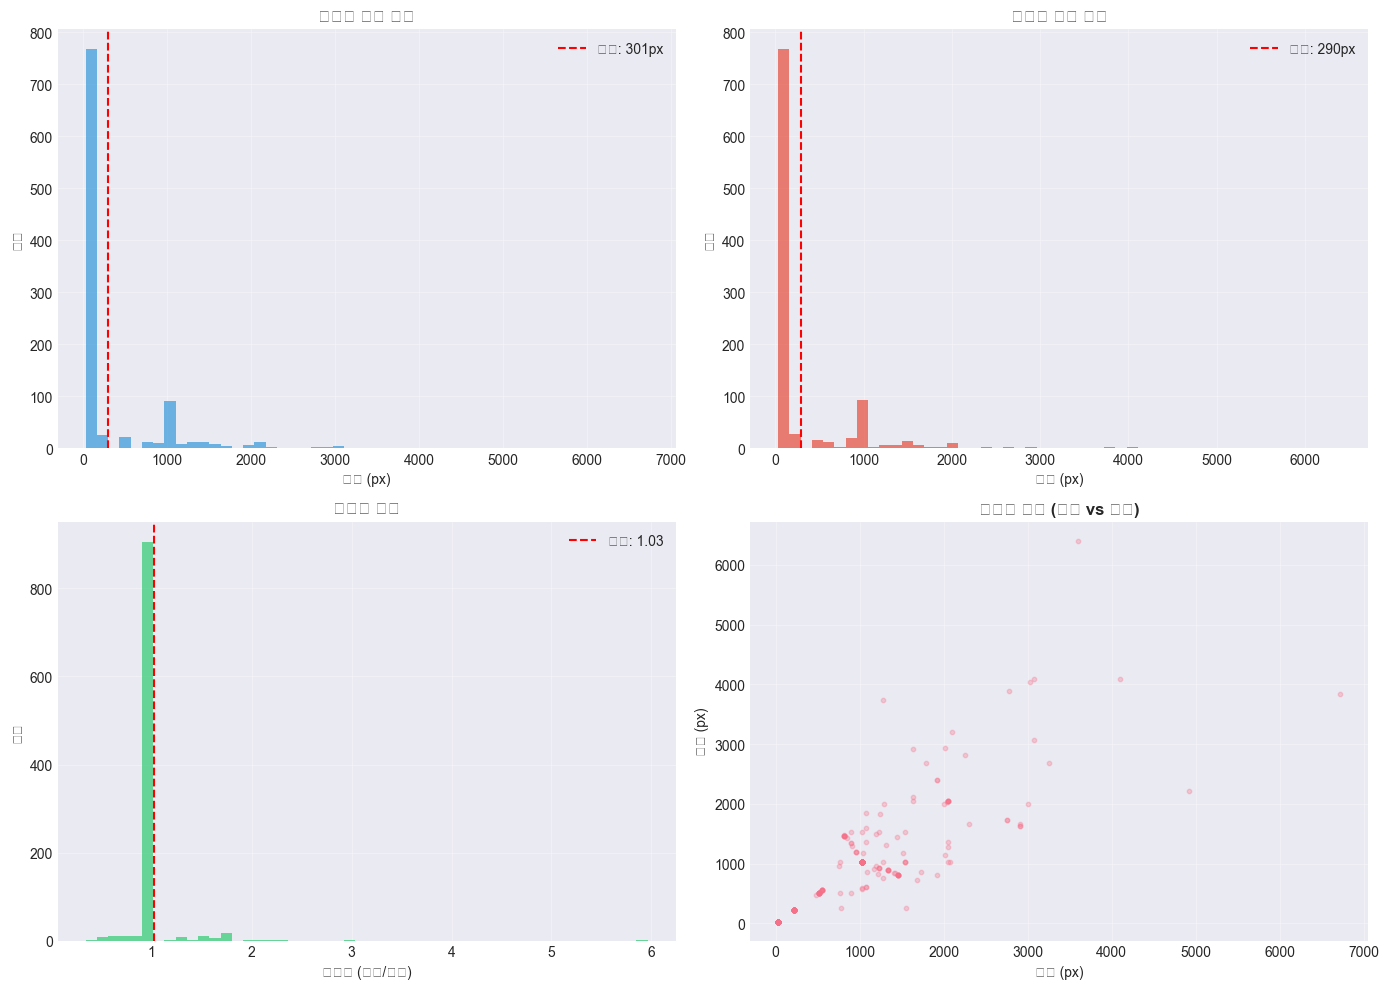

In [6]:
# 해상도 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 너비 분포
axes[0, 0].hist(resolution_stats['widths'], bins=50, color='#3498db', alpha=0.7)
axes[0, 0].set_title('이미지 너비 분포', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('너비 (px)')
axes[0, 0].set_ylabel('빈도')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axvline(np.mean(resolution_stats['widths']), color='red', linestyle='--', 
                   label=f'평균: {np.mean(resolution_stats["widths"]):.0f}px')
axes[0, 0].legend()

# 2. 높이 분포
axes[0, 1].hist(resolution_stats['heights'], bins=50, color='#e74c3c', alpha=0.7)
axes[0, 1].set_title('이미지 높이 분포', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('높이 (px)')
axes[0, 1].set_ylabel('빈도')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].axvline(np.mean(resolution_stats['heights']), color='red', linestyle='--',
                   label=f'평균: {np.mean(resolution_stats["heights"]):.0f}px')
axes[0, 1].legend()

# 3. 종횡비 분포
axes[1, 0].hist(resolution_stats['aspect_ratios'], bins=50, color='#2ecc71', alpha=0.7)
axes[1, 0].set_title('종횡비 분포', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('종횡비 (너비/높이)')
axes[1, 0].set_ylabel('빈도')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].axvline(np.mean(resolution_stats['aspect_ratios']), color='red', linestyle='--',
                   label=f'평균: {np.mean(resolution_stats["aspect_ratios"]):.2f}')
axes[1, 0].legend()

# 4. 해상도 산점도
sample_indices = np.random.choice(len(resolution_stats['widths']), 
                                 min(1000, len(resolution_stats['widths'])), 
                                 replace=False)
sample_widths = [resolution_stats['widths'][i] for i in sample_indices]
sample_heights = [resolution_stats['heights'][i] for i in sample_indices]

axes[1, 1].scatter(sample_widths, sample_heights, alpha=0.3, s=10)
axes[1, 1].set_title('해상도 분포 (너비 vs 높이)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('너비 (px)')
axes[1, 1].set_ylabel('높이 (px)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 4. 이미지 품질 분석 (노이즈, 밝기, 대비)


In [7]:
def analyze_image_quality(image_paths, sample_size=500):
    """
    이미지 품질 지표 분석
    
    Returns:
        quality_stats: 품질 통계 딕셔너리
    """
    brightness_values = []
    contrast_values = []
    sharpness_values = []
    
    # 샘플링
    if len(image_paths) > sample_size:
        import random
        random.seed(42)
        sampled_paths = random.sample(image_paths, sample_size)
    else:
        sampled_paths = image_paths
    
    print(f"🔍 {len(sampled_paths)}개 이미지의 품질 분석 중...")
    
    for img_path in tqdm(sampled_paths, desc="품질 분석"):
        try:
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            
            # BGR을 그레이스케일로 변환
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # 밝기 (평균 픽셀 값)
            brightness = np.mean(gray)
            brightness_values.append(brightness)
            
            # 대비 (표준편차)
            contrast = np.std(gray)
            contrast_values.append(contrast)
            
            # 선명도 (Laplacian 분산)
            laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
            sharpness_values.append(laplacian_var)
            
        except Exception as e:
            continue
    
    return {
        'brightness': brightness_values,
        'contrast': contrast_values,
        'sharpness': sharpness_values
    }

# 품질 분석
quality_stats = analyze_image_quality(stats['image_paths'])

print(f"\n✅ 품질 분석 완료!")
print(f"\n📊 이미지 품질 통계:")
print(f"   평균 밝기: {np.mean(quality_stats['brightness']):.2f} (0-255)")
print(f"   평균 대비: {np.mean(quality_stats['contrast']):.2f}")
print(f"   평균 선명도: {np.mean(quality_stats['sharpness']):.2f}")


🔍 500개 이미지의 품질 분석 중...


품질 분석:   0%|          | 0/500 [00:00<?, ?it/s]

품질 분석:   3%|▎         | 16/500 [00:00<00:03, 131.43it/s]

품질 분석:   6%|▌         | 31/500 [00:00<00:03, 130.86it/s]

품질 분석:   9%|▉         | 45/500 [00:00<00:05, 81.15it/s] 

품질 분석:  11%|█         | 55/500 [00:00<00:05, 81.66it/s]

품질 분석:  15%|█▍        | 74/500 [00:00<00:04, 102.14it/s]

품질 분석:  23%|██▎       | 116/500 [00:00<00:02, 177.18it/s]

품질 분석:  27%|██▋       | 136/500 [00:01<00:04, 85.97it/s] 

품질 분석:  32%|███▏      | 160/500 [00:01<00:03, 104.13it/s]

품질 분석:  38%|███▊      | 190/500 [00:01<00:02, 134.41it/s]

품질 분석:  43%|████▎     | 216/500 [00:01<00:01, 154.90it/s]

품질 분석:  47%|████▋     | 237/500 [00:01<00:01, 149.78it/s]

품질 분석:  52%|█████▏    | 259/500 [00:02<00:01, 154.73it/s]

품질 분석:  55%|█████▌    | 277/500 [00:02<00:02, 111.00it/s]

품질 분석:  58%|█████▊    | 292/500 [00:02<00:01, 111.28it/s]

품질 분석:  63%|██████▎   | 317/500 [00:02<00:01, 127.17it/s]

품질 분석:  66%|██████▋   | 332/500 [00:02<00:01, 120.00it/s]

품질 분석:  72%|███████▏  | 360/500 [00:02<00:00, 153.26it/s]

품질 분석:  76%|███████▌  | 378/500 [00:03<00:00, 125.99it/s]

품질 분석:  79%|███████▊  | 393/500 [00:03<00:00, 127.31it/s]

품질 분석:  82%|████████▏ | 412/500 [00:03<00:00, 129.56it/s]

품질 분석:  85%|████████▌ | 427/500 [00:03<00:00, 119.59it/s]

품질 분석:  88%|████████▊ | 440/500 [00:03<00:00, 116.25it/s]

품질 분석:  91%|█████████ | 453/500 [00:03<00:00, 74.35it/s] 

품질 분석:  98%|█████████▊| 489/500 [00:04<00:00, 113.01it/s]

품질 분석: 100%|██████████| 500/500 [00:04<00:00, 120.17it/s]


✅ 품질 분석 완료!

📊 이미지 품질 통계:
   평균 밝기: 115.29 (0-255)
   평균 대비: 52.40
   평균 선명도: 2205.73


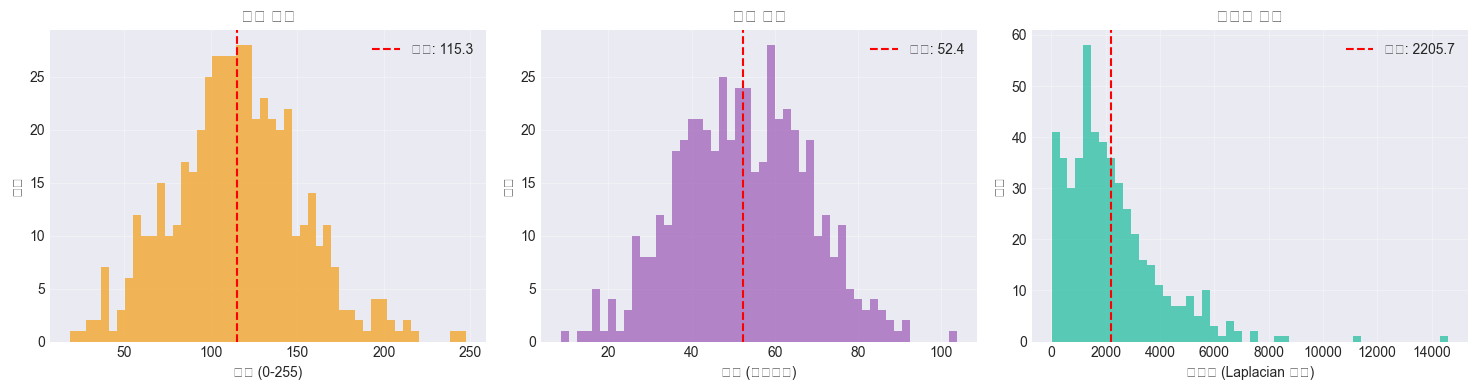

In [8]:
# 품질 지표 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. 밝기 분포
axes[0].hist(quality_stats['brightness'], bins=50, color='#f39c12', alpha=0.7)
axes[0].set_title('밝기 분포', fontsize=12, fontweight='bold')
axes[0].set_xlabel('밝기 (0-255)')
axes[0].set_ylabel('빈도')
axes[0].grid(alpha=0.3)
axes[0].axvline(np.mean(quality_stats['brightness']), color='red', linestyle='--',
                label=f'평균: {np.mean(quality_stats["brightness"]):.1f}')
axes[0].legend()

# 2. 대비 분포
axes[1].hist(quality_stats['contrast'], bins=50, color='#9b59b6', alpha=0.7)
axes[1].set_title('대비 분포', fontsize=12, fontweight='bold')
axes[1].set_xlabel('대비 (표준편차)')
axes[1].set_ylabel('빈도')
axes[1].grid(alpha=0.3)
axes[1].axvline(np.mean(quality_stats['contrast']), color='red', linestyle='--',
                label=f'평균: {np.mean(quality_stats["contrast"]):.1f}')
axes[1].legend()

# 3. 선명도 분포
axes[2].hist(quality_stats['sharpness'], bins=50, color='#1abc9c', alpha=0.7)
axes[2].set_title('선명도 분포', fontsize=12, fontweight='bold')
axes[2].set_xlabel('선명도 (Laplacian 분산)')
axes[2].set_ylabel('빈도')
axes[2].grid(alpha=0.3)
axes[2].axvline(np.mean(quality_stats['sharpness']), color='red', linestyle='--',
                label=f'평균: {np.mean(quality_stats["sharpness"]):.1f}')
axes[2].legend()

plt.tight_layout()
plt.show()


## 5. 샘플 이미지 시각화


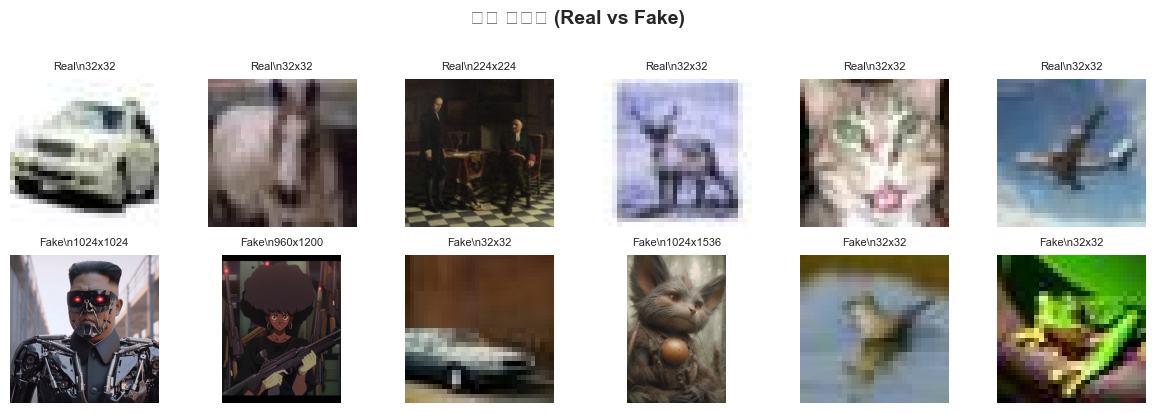

In [9]:
def visualize_samples(image_paths, categories, num_samples=12):
    """
    샘플 이미지 시각화
    
    Args:
        image_paths: 이미지 경로 리스트
        categories: 카테고리 리스트
        num_samples: 표시할 샘플 수
    """
    # 카테고리별로 샘플 선택
    real_paths = [path for path, cat in zip(image_paths, categories) if cat == 'real']
    fake_paths = [path for path, cat in zip(image_paths, categories) if cat == 'fake']
    
    # 각 카테고리에서 샘플 선택
    import random
    random.seed(42)
    
    num_per_category = num_samples // 2
    selected_real = random.sample(real_paths, min(num_per_category, len(real_paths)))
    selected_fake = random.sample(fake_paths, min(num_per_category, len(fake_paths)))
    
    # 시각화
    fig, axes = plt.subplots(2, num_per_category, figsize=(num_per_category * 2, 4))
    
    # Real 이미지
    for idx, img_path in enumerate(selected_real):
        try:
            img = Image.open(img_path)
            axes[0, idx].imshow(img)
            axes[0, idx].set_title(f'Real\\n{img.size[0]}x{img.size[1]}', fontsize=8)
            axes[0, idx].axis('off')
        except:
            axes[0, idx].axis('off')
    
    # Fake 이미지
    for idx, img_path in enumerate(selected_fake):
        try:
            img = Image.open(img_path)
            axes[1, idx].imshow(img)
            axes[1, idx].set_title(f'Fake\\n{img.size[0]}x{img.size[1]}', fontsize=8)
            axes[1, idx].axis('off')
        except:
            axes[1, idx].axis('off')
    
    plt.suptitle('샘플 이미지 (Real vs Fake)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# 샘플 시각화
if len(stats['image_paths']) > 0:
    visualize_samples(stats['image_paths'], stats['categories'], num_samples=12)
else:
    print("⚠️  시각화할 이미지를 찾을 수 없습니다.")


## 6. 데이터셋별 특성 비교


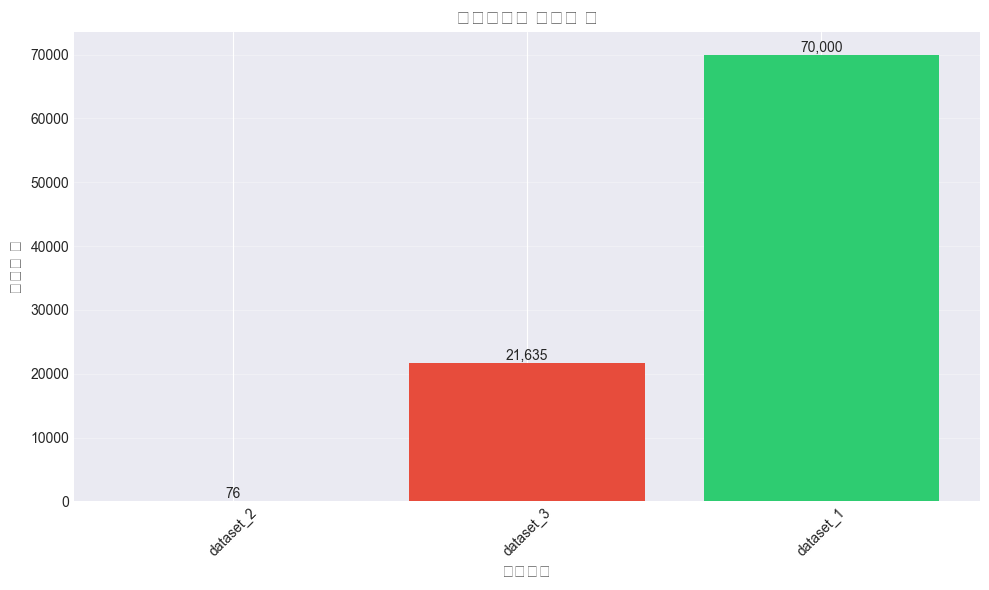

\n📊 데이터셋별 통계:
  dataset  count
dataset_2     76
dataset_3  21635
dataset_1  70000


In [10]:
# 데이터셋별 통계 비교
if stats['by_dataset']:
    dataset_df = pd.DataFrame({
        'dataset': list(stats['by_dataset'].keys()),
        'count': list(stats['by_dataset'].values())
    })
    
    # 시각화
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    bars = ax.bar(dataset_df['dataset'], dataset_df['count'], color=['#3498db', '#e74c3c', '#2ecc71'])
    ax.set_title('데이터셋별 이미지 수', fontsize=14, fontweight='bold')
    ax.set_ylabel('이미지 수', fontsize=12)
    ax.set_xlabel('데이터셋', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    # 값 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=10)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("\\n📊 데이터셋별 통계:")
    print(dataset_df.to_string(index=False))
else:
    print("⚠️  데이터셋별 정보를 찾을 수 없습니다.")


## 7. 문제 정의: "왜 이 데이터가 어려운가?"


In [11]:
# 문제 정의 및 어려움 분석
print("=" * 70)
print("🔍 문제 정의: 왜 이 데이터가 어려운가?")
print("=" * 70)

difficulties = []

# 1. 클래스 불균형
if len(stats['by_category']) >= 2:
    counts = list(stats['by_category'].values())
    imbalance = max(counts) / min(counts)
    if imbalance > 3:
        difficulties.append({
            'issue': '클래스 불균형',
            'severity': '높음',
            'description': f'클래스 비율이 {imbalance:.1f}:1로 불균형합니다.',
            'impact': '모델이 다수 클래스에 편향될 수 있음',
            'solution': '데이터 증강, 클래스 가중치, 샘플링 전략 필요'
        })

# 2. 해상도 다양성
if resolution_stats['resolutions']:
    width_std = np.std(resolution_stats['widths'])
    height_std = np.std(resolution_stats['heights'])
    if width_std > 200 or height_std > 200:
        difficulties.append({
            'issue': '해상도 다양성',
            'severity': '중간',
            'description': f'해상도 표준편차가 큽니다 (너비: {width_std:.0f}px, 높이: {height_std:.0f}px)',
            'impact': '모델 학습 시 일관성 있는 특징 추출이 어려울 수 있음',
            'solution': '이미지 리사이즈 및 정규화 필요'
        })

# 3. 이미지 품질
if quality_stats['sharpness']:
    avg_sharpness = np.mean(quality_stats['sharpness'])
    if avg_sharpness < 100:
        difficulties.append({
            'issue': '이미지 선명도',
            'severity': '중간',
            'description': f'평균 선명도가 낮습니다 ({avg_sharpness:.1f})',
            'impact': '노이즈가 많거나 흐린 이미지로 인해 특징 추출이 어려울 수 있음',
            'solution': '전처리(노이즈 제거, 샤프닝) 또는 데이터 필터링 고려'
        })

# 4. 데이터셋 다양성
if len(stats['by_dataset']) > 1:
    dataset_counts = list(stats['by_dataset'].values())
    dataset_imbalance = max(dataset_counts) / min(dataset_counts)
    if dataset_imbalance > 10:
        difficulties.append({
            'issue': '데이터셋 불균형',
            'severity': '중간',
            'description': f'데이터셋 간 크기 차이가 큽니다 ({dataset_imbalance:.1f}:1)',
            'impact': '특정 데이터셋에 과적합될 수 있음',
            'solution': '데이터셋 간 균형 조정 또는 교차 검증 전략 필요'
        })

# 결과 출력
if difficulties:
    for i, diff in enumerate(difficulties, 1):
        print(f"\\n{i}. {diff['issue']} [{diff['severity']}]")
        print(f"   설명: {diff['description']}")
        print(f"   영향: {diff['impact']}")
        print(f"   해결책: {diff['solution']}")
else:
    print("\\n✅ 특별한 어려움을 발견하지 못했습니다.")

print("\\n" + "=" * 70)
print("📝 종합 분석 요약")
print("=" * 70)
print(f"총 이미지 수: {stats['total_images']:,}개")
print(f"클래스 수: {len(stats['by_category'])}개")
if stats['by_category']:
    for cat, count in stats['by_category'].items():
        print(f"  - {cat}: {count:,}개")
print(f"\\n주요 도전 과제: {len(difficulties)}개 발견")
print("\\n권장 사항:")
print("1. 데이터 전처리 및 정규화")
print("2. 클래스 불균형 해결을 위한 데이터 증강")
print("3. 다양한 모델 아키텍처 실험 (CNN, ViT)")
print("4. 교차 검증을 통한 모델 성능 검증")


🔍 문제 정의: 왜 이 데이터가 어려운가?
\n1. 해상도 다양성 [중간]
   설명: 해상도 표준편차가 큽니다 (너비: 622px, 높이: 609px)
   영향: 모델 학습 시 일관성 있는 특징 추출이 어려울 수 있음
   해결책: 이미지 리사이즈 및 정규화 필요
\n2. 데이터셋 불균형 [중간]
   설명: 데이터셋 간 크기 차이가 큽니다 (921.1:1)
   영향: 특정 데이터셋에 과적합될 수 있음
   해결책: 데이터셋 간 균형 조정 또는 교차 검증 전략 필요
\n======================================================================
📝 종합 분석 요약
총 이미지 수: 91,711개
클래스 수: 2개
  - real: 63,780개
  - fake: 27,855개
\n주요 도전 과제: 2개 발견
\n권장 사항:
1. 데이터 전처리 및 정규화
2. 클래스 불균형 해결을 위한 데이터 증강
3. 다양한 모델 아키텍처 실험 (CNN, ViT)
4. 교차 검증을 통한 모델 성능 검증
